In [45]:
import numpy as np
import zarr

z_csc = zarr.open(
    'https://storage.googleapis.com/scrna-seqbrowser/relaxed_epdsc_annotated_data_csc_full.zarr',
    mode='r'
)

# Get correct dimensions
# n_genes = z_csc['X']['indptr'].shape[0] - 1
# n_cells = z_csc['obs'][list(z_csc['obs'].keys())[0]].shape[0]

# print(f"Number of genes: {n_genes}")
# print(f"Number of cells: {n_cells}")

In [64]:
genes = z_csc['var']['_index'][:].tolist()

# find BRCA1 index
brca1_index = genes.index('BRCA1')
krt10_index = genes.index('KRT10')
print(brca1_index)
print(krt10_index)

10030
9971


In [165]:
from scipy.sparse import csc_matrix

def get_genes_batch(z_csc, gene_indices, layer='X'):
    n_cells = z_csc['obs'][next(iter(z_csc['obs'].array_keys()))].shape[0]
    csc = z_csc['X'] if layer == 'X' else z_csc['layers'][layer]
    indptr, indices, data = csc['indptr'], csc['indices'], csc['data']
    sorted_indices = sorted(enumerate(gene_indices), key=lambda x: x[1])
    sorted_genes = [x[1] for x in sorted_indices]
    original_order = [x[0] for x in sorted_indices]
    
    if sorted_genes:
        min_gene, max_gene = sorted_genes[0], sorted_genes[-1]
        indptr_full = indptr[min_gene:max_gene+2]
        start_idx = indptr_full[0]
        end_idx = indptr_full[-1]
        if start_idx < end_idx:
            indices_batch = indices[start_idx:end_idx]
            data_batch = data[start_idx:end_idx]
        else:
            indices_batch = np.array([])
            data_batch = np.array([])
    else:
        return csc_matrix((n_cells, 0), dtype=np.float32)
    
    # Initialize sparse matrix
    expr_mat = csc_matrix((n_cells, len(gene_indices)), dtype=np.float32)
    row_indices = []
    col_indices = []
    data_values = []
    
    # Fill sparse matrix
    for i, gene_idx in enumerate(sorted_genes):
        rel_pos = gene_idx - min_gene
        s_rel = indptr_full[rel_pos] - start_idx
        e_rel = indptr_full[rel_pos + 1] - start_idx
        if s_rel < e_rel:
            orig_i = original_order[i]
            row_indices.extend(indices_batch[s_rel:e_rel])
            col_indices.extend([orig_i] * (e_rel - s_rel))
            data_values.extend(data_batch[s_rel:e_rel])
    
    # Construct sparse matrix
    if row_indices:
        expr_mat = csc_matrix((data_values, (row_indices, col_indices)), 
                            shape=(n_cells, len(gene_indices)), dtype=np.float32)
    
    return expr_mat

def get_genes_batch2(z_csc, gene_indices, layer='X'):
    n_cells = z_csc['obs'][next(iter(z_csc['obs'].array_keys()))].shape[0]
    csc = z_csc['X'] if layer == 'X' else z_csc['layers'][layer]
    indptr, indices, data = csc['indptr'], csc['indices'], csc['data']
    sorted_indices = sorted(enumerate(gene_indices), key=lambda x: x[1])
    sorted_genes = [x[1] for x in sorted_indices]
    original_order = [x[0] for x in sorted_indices]
    if sorted_genes:
        min_gene, max_gene = sorted_genes[0], sorted_genes[-1]
        indptr_full = indptr[min_gene:max_gene+2]
        start_idx = indptr_full[0]
        end_idx = indptr_full[-1]
        if start_idx < end_idx:
            indices_batch = indices[start_idx:end_idx]
            data_batch = data[start_idx:end_idx]
        else:
            indices_batch = np.array([])
            data_batch = np.array([])
    else:
        return np.zeros((n_cells, 0), dtype=np.float32)
    expr_mat = np.zeros((n_cells, len(gene_indices)), dtype=np.float32)
    for i, gene_idx in enumerate(sorted_genes):
        rel_pos = gene_idx - min_gene
        s_rel = indptr_full[rel_pos] - start_idx
        e_rel = indptr_full[rel_pos + 1] - start_idx
        if s_rel < e_rel:
            orig_i = original_order[i]
            expr_mat[indices_batch[s_rel:e_rel], orig_i] = data_batch[s_rel:e_rel]
    return expr_mat

def get_genes_batch3(z_csc, gene_indices, layer='X', batch_size=1000):
    n_cells = z_csc['obs'][next(iter(z_csc['obs'].array_keys()))].shape[0]
    csc = z_csc['X'] if layer == 'X' else z_csc['layers'][layer]
    
    # Cache indptr to reduce cloud fetches
    indptr = csc['indptr'][:]
    indices = csc['indices']
    data = csc['data']
    
    # Sort gene indices
    sorted_indices = sorted(enumerate(gene_indices), key=lambda x: x[1])
    sorted_genes = [x[1] for x in sorted_indices]
    original_order = [x[0] for x in sorted_indices]
    
    if not sorted_genes:
        return csc_matrix((n_cells, 0), dtype=np.float32)
    
    # Initialize lists for non-zero entries
    all_row_indices = []
    all_col_indices = []
    all_data_values = []
    
    # Process genes in batches
    for batch_start in range(0, len(sorted_genes), batch_size):
        batch_end = min(batch_start + batch_size, len(sorted_genes))
        batch_genes = sorted_genes[batch_start:batch_end]
        
        if not batch_genes:
            continue
        
        # Get the range of data we need to fetch
        min_gene = batch_genes[0]
        max_gene = batch_genes[-1]
        
        # Fetch indptr for the full range
        range_indptr = indptr[min_gene:max_gene+2]
        start_idx = range_indptr[0]
        end_idx = range_indptr[-1]
        
        if start_idx < end_idx:
            # Fetch the contiguous block of data
            batch_indices = indices[start_idx:end_idx]
            batch_data = data[start_idx:end_idx]
        else:
            batch_indices = np.array([], dtype=np.int32)
            batch_data = np.array([], dtype=np.float32)
        
        # Process each gene in this batch
        for local_i, gene_idx in enumerate(batch_genes):
            # Calculate relative position within the fetched range
            rel_pos = gene_idx - min_gene
            s_rel = range_indptr[rel_pos] - start_idx
            e_rel = range_indptr[rel_pos + 1] - start_idx
            
            if s_rel < e_rel:
                # Global column index (position in the sorted list)
                global_col_idx = batch_start + local_i
                
                # Extract data for this specific gene
                gene_row_indices = batch_indices[s_rel:e_rel]
                gene_data = batch_data[s_rel:e_rel]
                
                # Add to global lists
                all_row_indices.append(gene_row_indices)
                all_col_indices.append(np.full(len(gene_row_indices), global_col_idx, dtype=np.int32))
                all_data_values.append(gene_data)
    
    # Combine all non-zero entries
    if not all_row_indices:
        return csc_matrix((n_cells, len(gene_indices)), dtype=np.float32)
    
    all_row_indices = np.concatenate(all_row_indices)
    all_col_indices = np.concatenate(all_col_indices)
    all_data_values = np.concatenate(all_data_values)
    
    # Create final sparse matrix
    result_mat = csc_matrix(
        (all_data_values, (all_row_indices, all_col_indices)),
        shape=(n_cells, len(gene_indices)),
        dtype=np.float32
    )
    
    # Reorder columns to match original gene_indices order
    inverse_order = np.argsort(original_order)
    result_mat = result_mat[:, inverse_order]
    
    return result_mat

In [166]:
result = get_genes_batch(z_csc, [brca1_index, krt10_index], layer='X')
result2 = get_genes_batch2(z_csc, [brca1_index, krt10_index], layer='X')
result3 = get_genes_batch3(z_csc, [brca1_index, krt10_index], layer='X')

In [127]:
result = get_genes_batch(z_csc, list(range(1000)), layer='X')
result2 = get_genes_batch2(z_csc, list(range(1000)), layer='X')
result3 = get_genes_batch3(z_csc, list(range(1000)), layer='X')

In [167]:
result.toarray()

array([[0.       , 3.5344663],
       [0.       , 2.7822804],
       [0.       , 4.0671716],
       ...,
       [0.       , 3.0211897],
       [0.       , 0.       ],
       [0.       , 2.0134704]], shape=(8007, 2), dtype=float32)

In [168]:
result3.toarray()

array([[0.       , 3.5344663],
       [0.       , 2.7822804],
       [0.       , 4.0671716],
       ...,
       [0.       , 3.0211897],
       [0.       , 0.       ],
       [0.       , 2.0134704]], shape=(8007, 2), dtype=float32)

In [126]:
print(result.mean())  # careful: includes implicit zeros
print(result2.mean())
print(result3.mean())

0.5254963
0.5254963
6.6943235


In [63]:
result.toarray()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8007, 1), dtype=float32)

In [62]:
result3.toarray()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8007, 1), dtype=float32)


Testing specific indices [brca1_index, krt10_index]...
Peak RAM Usage: 0.00 MB
Execution Time: 0.00 seconds

Testing range(0, 1000)...
Peak RAM Usage: 14.16 MB
Execution Time: 0.30 seconds

Testing range(0, 5000)...
Peak RAM Usage: 98.24 MB
Execution Time: 0.60 seconds

Testing range(0, 10000)...
Peak RAM Usage: 226.58 MB
Execution Time: 1.20 seconds

Testing range(0, 15000)...
Peak RAM Usage: 399.57 MB
Execution Time: 2.22 seconds

Summary of Results:
Num Genes | Peak RAM (MB) | Execution Time (s)
----------------------------------------
        2 |         0.00 |              0.00
     1000 |        14.16 |              0.30
     5000 |        98.24 |              0.60
    10000 |       226.58 |              1.20
    15000 |       399.57 |              2.22


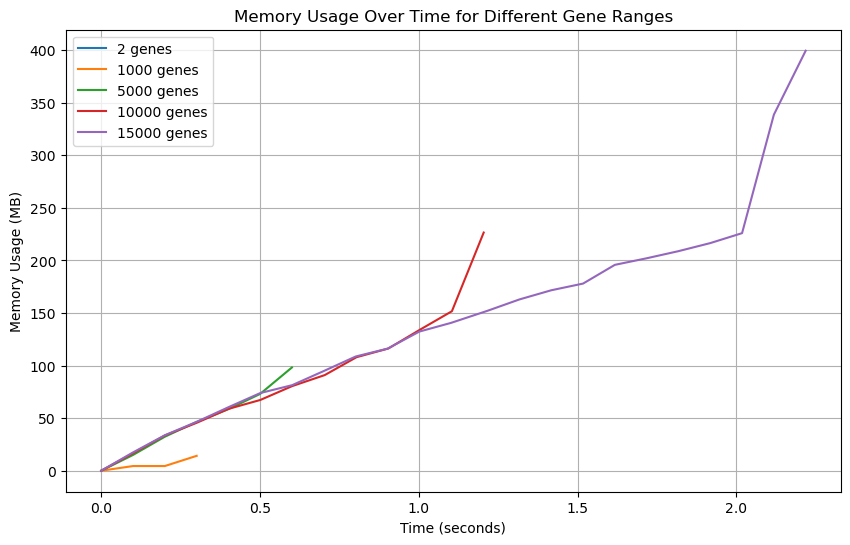

In [164]:
import tracemalloc
import time
import numpy as np
import zarr
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from contextlib import contextmanager

# Optimized get_genes_batch for non-contiguous indices
def get_genes_batch(z_csc, gene_indices, layer='X', batch_size=1000):
    n_cells = z_csc['obs'][next(iter(z_csc['obs'].array_keys()))].shape[0]
    csc = z_csc['X'] if layer == 'X' else z_csc['layers'][layer]
    
    # Cache indptr to reduce cloud fetches
    indptr = csc['indptr'][:]
    indices = csc['indices']
    data = csc['data']
    
    # Sort gene indices
    sorted_indices = sorted(enumerate(gene_indices), key=lambda x: x[1])
    sorted_genes = [x[1] for x in sorted_indices]
    original_order = [x[0] for x in sorted_indices]
    
    if not sorted_genes:
        return csc_matrix((n_cells, 0), dtype=np.float32)
    
    # Initialize lists for non-zero entries
    all_row_indices = []
    all_col_indices = []
    all_data_values = []
    
    # Process genes in batches
    for batch_start in range(0, len(sorted_genes), batch_size):
        batch_end = min(batch_start + batch_size, len(sorted_genes))
        batch_genes = sorted_genes[batch_start:batch_end]
        
        if not batch_genes:
            continue
        
        # Get the range of data we need to fetch
        min_gene = batch_genes[0]
        max_gene = batch_genes[-1]
        
        # Fetch indptr for the full range
        range_indptr = indptr[min_gene:max_gene+2]
        start_idx = range_indptr[0]
        end_idx = range_indptr[-1]
        
        if start_idx < end_idx:
            # Fetch the contiguous block of data
            batch_indices = indices[start_idx:end_idx]
            batch_data = data[start_idx:end_idx]
        else:
            batch_indices = np.array([], dtype=np.int32)
            batch_data = np.array([], dtype=np.float32)
        
        # Process each gene in this batch
        for local_i, gene_idx in enumerate(batch_genes):
            # Calculate relative position within the fetched range
            rel_pos = gene_idx - min_gene
            s_rel = range_indptr[rel_pos] - start_idx
            e_rel = range_indptr[rel_pos + 1] - start_idx
            
            if s_rel < e_rel:
                # Global column index (position in the sorted list)
                global_col_idx = batch_start + local_i
                
                # Extract data for this specific gene
                gene_row_indices = batch_indices[s_rel:e_rel]
                gene_data = batch_data[s_rel:e_rel]
                
                # Add to global lists
                all_row_indices.append(gene_row_indices)
                all_col_indices.append(np.full(len(gene_row_indices), global_col_idx, dtype=np.int32))
                all_data_values.append(gene_data)
    
    # Combine all non-zero entries
    if not all_row_indices:
        return csc_matrix((n_cells, len(gene_indices)), dtype=np.float32)
    
    all_row_indices = np.concatenate(all_row_indices)
    all_col_indices = np.concatenate(all_col_indices)
    all_data_values = np.concatenate(all_data_values)
    
    # Create final sparse matrix
    result_mat = csc_matrix(
        (all_data_values, (all_row_indices, all_col_indices)),
        shape=(n_cells, len(gene_indices)),
        dtype=np.float32
    )
    
    # Reorder columns to match original gene_indices order
    inverse_order = np.argsort(original_order)
    result_mat = result_mat[:, inverse_order]
    
    return result_mat

# Memory tracking context manager
@contextmanager
def memory_tracker(sample_interval=0.1):
    tracemalloc.start()
    memory_samples = []
    time_samples = []
    start_time = time.time()
    
    def sample_memory():
        while tracking[0]:
            current, peak = tracemalloc.get_traced_memory()
            memory_samples.append(current / 1024 / 1024)
            time_samples.append(time.time() - start_time)
            time.sleep(sample_interval)
    
    import threading
    tracking = [True]
    sampler_thread = threading.Thread(target=sample_memory)
    sampler_thread.start()
    
    try:
        yield memory_samples, time_samples
    finally:
        tracking[0] = False
        sampler_thread.join()
        tracemalloc.stop()

# Main execution
def measure_and_plot_ranges():
    z_csc = zarr.open(
        'https://storage.googleapis.com/scrna-seqbrowser/relaxed_epdsc_annotated_data_csc_full.zarr',
        mode='r'
    )
    
    gene_ranges = [1000, 5000, 10000, 15000]
    results = []
    all_memory_samples = {}
    all_time_samples = {}
    
    # Test specific indices
    brca1_index = 10030
    krt10_index = 9971
    print("\nTesting specific indices [brca1_index, krt10_index]...")
    with memory_tracker(sample_interval=0.1) as (memory_samples, time_samples):
        result = get_genes_batch(z_csc, [brca1_index, krt10_index], layer='X')
    
    peak_memory = max(memory_samples) if memory_samples else 0
    execution_time = time_samples[-1] if time_samples else 0
    print(f"Peak RAM Usage: {peak_memory:.2f} MB")
    print(f"Execution Time: {execution_time:.2f} seconds")
    results.append({
        'num_genes': 2,
        'peak_memory_mb': peak_memory,
        'execution_time_s': execution_time
    })
    all_memory_samples[2] = memory_samples
    all_time_samples[2] = time_samples
    
    # Test gene ranges
    for num_genes in gene_ranges:
        print(f"\nTesting range(0, {num_genes})...")
        with memory_tracker(sample_interval=0.1) as (memory_samples, time_samples):
            result = get_genes_batch(z_csc, list(range(num_genes)), layer='X')
        
        peak_memory = max(memory_samples) if memory_samples else 0
        execution_time = time_samples[-1] if time_samples else 0
        
        results.append({
            'num_genes': num_genes,
            'peak_memory_mb': peak_memory,
            'execution_time_s': execution_time
        })
        
        all_memory_samples[num_genes] = memory_samples
        all_time_samples[num_genes] = time_samples
        
        print(f"Peak RAM Usage: {peak_memory:.2f} MB")
        print(f"Execution Time: {execution_time:.2f} seconds")
    
    print("\nSummary of Results:")
    print("Num Genes | Peak RAM (MB) | Execution Time (s)")
    print("-" * 40)
    for res in results:
        print(f"{res['num_genes']:9d} | {res['peak_memory_mb']:12.2f} | {res['execution_time_s']:17.2f}")
    
    plt.figure(figsize=(10, 6))
    for num_genes in all_memory_samples:
        plt.plot(all_time_samples[num_genes], all_memory_samples[num_genes], 
                 label=f'{num_genes} genes')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage Over Time for Different Gene Ranges')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return results

if __name__ == "__main__":
    results = measure_and_plot_ranges()

In [95]:
result = get_genes_batch(z_csc, list(range(10000)), layer='X')

In [97]:
result = get_genes_batch(z_csc, [brca1_index, krt10_index], layer='X')

In [98]:
result

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 8304 stored elements and shape (8007, 2)>